In [1]:
from dotenv import load_dotenv
# put your secret keys in your .env
# For instance, if you are using OpenAI, your .env should contain
# export OPENAI_API_KEY = "sk-......."
load_dotenv()

True

In [2]:
# !pip install google-genai

In [3]:
# !pip install agentjo

# Text Generation

In [4]:
from google import genai
import os

client = genai.Client(api_key=os.environ['GEMINI_API_KEY'])

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=["How does AI work? Explain in 1 sentence."])
print(response.text)

AI works by training algorithms on large datasets to recognize patterns, make predictions, and automate tasks.



# Image Analysis

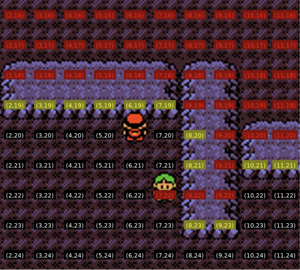

In [5]:
from PIL import Image
from IPython.display import display

# Open the image
image = Image.open("map.png")

# Resize image while maintaining aspect ratio
image.thumbnail((300, 300))  # Set max width and height

# Display the resized image
display(image)

In [6]:
from PIL import Image

# Open the image
image = Image.open("map.png")

response = client.models.generate_content(    
    model="gemini-2.0-flash",
    contents=[image, "Describe the sprite in each coordinate of the map"])
print(response.text)

Here's the breakdown of the sprite in each coordinate, based on the image provided:

*   **(2,16) to (11,16):** Walls
*   **(2,17) to (11,17):** Walls
*   **(2,18) to (11,18):** Walls
*   **(2,19) to (11,19):** Water
*   **(2,20) to (5,20):** Ground
*   **(6,20):** Player
*   **(7,20) to (11,20):** Ground
*   **(2,21) to (7,21):** Ground
*   **(8,21) to (11,21):** Ground
*   **(2,22) to (6,22):** Ground
*   **(7,22):** Player
*   **(8,22) to (11,22):** Ground
*   **(2,23) to (11,23):** Ground
*   **(2,24) to (11,24):** Ground


In [7]:
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=[image, "How can the character at (6, 20) get to the NPC?"])
print(response.text)

The character at (6, 20) needs to move right to (7, 20), down to (7, 21), and then down again to (7, 22), where the NPC is located.


# Interface with AgentJo

In [8]:
from agentjo import strict_json

In [9]:
def replace_image_marker_gemini(func):
    """
    A decorator that scans the user prompt for markers in the form <<filename>>.
    For each marker, it attempts to load an image either from a local file (e.g., .png, .jpg, etc.)
    or from an HTTP URL, and replaces the marker with the corresponding image object.
    Local images are loaded via PIL.Image, while HTTP images are fetched using requests
    and wrapped as a types.Part for the Gemini API.
    The resulting list (mixing text and images) is passed to the wrapped function.
    """
    def wrapper(system_prompt: str, user_prompt: str):
        import re
        parts = re.split(r'<<(.*?)>>', user_prompt)
        new_contents = []
        for idx, part in enumerate(parts):
            if idx % 2 == 1:
                image_source = part.strip()
                # Check if the marker is an HTTP(S) URL.
                if image_source.startswith("http://") or image_source.startswith("https://"):
                    try:
                        import requests
                        response = requests.get(image_source)
                        response.raise_for_status()
                        from google.genai import types
                        # Try to get the MIME type from the response headers; default to image/jpeg.
                        mime_type = response.headers.get("Content-Type", "image/jpeg")
                        new_contents.append(types.Part.from_bytes(data=response.content, mime_type=mime_type))
                    except Exception as e:
                        # If fetching the image fails, leave the marker as text.
                        new_contents.append(f"<<{part}>>")
                else:
                    try:
                        from PIL import Image
                        image = Image.open(image_source)
                        new_contents.append(image)
                    except Exception as e:
                        new_contents.append(f"<<{part}>>")
            else:
                if part:
                    new_contents.append(part)
        return func(system_prompt, new_contents)
    return wrapper

@replace_image_marker_gemini
def llm(system_prompt: str, user_prompt):
    """
    Calls the Gemini API. If the user_prompt has been processed into a list (via our decorator),
    it is used directly as the contents; otherwise, the user_prompt is wrapped in a list.
    """
    from google.genai import types
    from google import genai
    import os

    client = genai.Client(api_key=os.environ['GEMINI_API_KEY'])

    # Use the user_prompt directly if it's a list, otherwise wrap it.
    contents = user_prompt if isinstance(user_prompt, list) else [user_prompt]

    response = client.models.generate_content(
        model="gemini-2.0-flash",
        config=types.GenerateContentConfig(system_instruction=system_prompt, temperature=0),
        contents=contents
    )
    return response.text

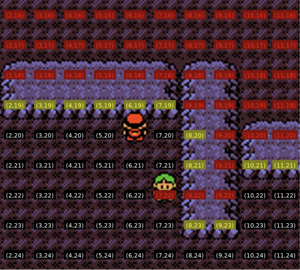

In [10]:
from PIL import Image
from IPython.display import display

# Open the image
image = Image.open("map.png")

# Resize image while maintaining aspect ratio
image.thumbnail((300, 300))  # Set max width and height

# Display the resized image
display(image)

In [11]:
from agentjo import strict_json

res = strict_json('''You are a friendly assistant to play a game for the player. 
The player is at the centre of the screen.
Coordinates are given as (x, y), x being the left to right axis, y being the up to down axis
Left moves in the negative x direction, e.g. (x, y) to (x-1, y)
Right moves in the positive x direction, e.g. (x, y) to (x+1, y),
Up moves in the negative y direction, e.g. (x, y) to (x, y-1)
Down moves in the positive y direction, e.g. (x, y) to (x, y+1)
A is typically used for confirming actions, selecting options, and interacting with elements in the game
B is typically used to cancel actions, go back to the previous screen, or exit menus
Start is used to open the main menu, allowing players to access options like the Pokémon menu, bag, items, and settings
Select is used to register key items, allowing players to quickly access them during gameplay''',
      "Based on the image <<map.png>>, what should the player do to talk to the NPC?",
      output_format = {"Thoughts": '''State where the player is, where the destination is, 
and the actions needed to navigate there, type: str''',
                       "Action List": "type: list[Enum['Up', 'Down', 'Left', 'Right', 'A', 'B', 'Start', 'Select']]"},
      llm = llm)

NameError: name 'llm' is not defined

In [ ]:
res

# Multiple Images

In [ ]:
from PIL import Image
from IPython.display import display

# Open the images
image1 = Image.open("map1.png")
image2 = Image.open("map2.png")

# Optionally resize both images to a common max height while preserving aspect ratio
max_height = 300
image1.thumbnail((image1.width, max_height))
image2.thumbnail((image2.width, max_height))

# Get the sizes of the resized images
width1, height1 = image1.size
width2, height2 = image2.size

# Create a new image with a width that is the sum of both images and a height equal to the max of the two heights
new_width = width1 + width2
new_height = max(height1, height2)
new_image = Image.new('RGB', (new_width, new_height), (255, 255, 255))  # white background

# Paste the images side by side
new_image.paste(image1, (0, 0))
new_image.paste(image2, (width1, 0))

# Display the concatenated image
display(new_image)

In [ ]:
res = strict_json('''You are a friendly assistant to play a game for the player. 
You are to describe what happened in previous game states''',
      "Previous state 1: <<map1.png>>, state 2: <<map2.png>>",
      output_format = {"State 1": "Describe first state",
                      "State 2": "Describe second state",
                      "Thoughts": "Describe what has happened"},
      llm = llm)

In [ ]:
res